**Background:**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**

* age : age of customer (numeric)

* job : type of job (categorical)

* marital : marital status (categorical)

* education (categorical)

* default: has credit in default? (binary)

* balance: average yearly balance, in euros (numeric)

* housing: has a housing loan? (binary)

* loan: has personal loan? (binary)

* contact: contact communication type (categorical)

* day: last contact day of the month (numeric)

* month: last contact month of year (categorical)

* duration: last contact duration, in seconds (numeric)

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (desired target):**

* y - has the client subscribed to a term deposit? (binary)

**Download Data:**

https://drive.google.com/file/d/1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7

**Goal(s):**

* Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

**Success Metric(s):**

* Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Bonus(es):**

* We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

* What makes the customers buy? Tell us which feature we should be focusing more on.

**Submission Instructions:**
* Project should be implemented with Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("term-deposit-marketing-2020.csv"); data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
#Instead of keeping the month and day seperately, I merge it in one column. 
data["date"] = data["month"].map(str) + "-" + data["day"].map(str)

In [4]:
#calculate days passed after last time contact and save it in the column. Last day is taken as today.
data["days_without_contact"] = (pd.to_datetime(data.date,format="%b-%d").max() - pd.to_datetime(data.date,format="%b-%d")).dt.days

In [5]:
#instead of keeping dates, days passed after last time contacted is preserved. Thus we construct a relationship
#between the duration and whether a client subscribe a term deposit or not.
data.drop(columns=["day","month","date"],inplace=True)

In [6]:
#Reorganising the columns
data = data[["age","job","marital","education","default","balance","housing","loan","contact","days_without_contact","duration","campaign","y"]]

In [7]:
#Instead of yes, 1 is used and instead of no, 0 is used since models cannot handle categorical variables.
data.y = data.y.replace({"no":0,"yes":1})
#Same procedures applied all the columns that contains yes and no.
#pd.get_dummies functions also applicible
data.default = data.default.replace({"no":0,"yes":1})
data.housing = data.housing.replace({"no":0,"yes":1})
data.loan = data.loan.replace({"no":0,"yes":1})

In [8]:
#Detecting the unknown variables
for i in data.columns:
    print(i,data[i].unique())

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default [0 1]
balance [  2143     29      2 ...   7222   3402 102127]
housing [1 0]
loan [0 1]
contact ['unknown' 'cellular' 'telephone']
days_without_contact [236 235 234 233 232 229 228 227 226 225 222 221 220 218 215 214 213 212
 211 208 207 206 205 204 201 199 198 194 193 192 191 190 187 186 185 184
 183 180 179 178 177 176 173 172 171 170 169 166 165 164 163 162 159 158
 157 156 155 152 151 150 149 145 144 143 142 141 138 137 136 135 131 130
 129 128 127 124 123 122 121 120  71  70  69  68  67  66  65  64  63  62
  61  60  

In [9]:
data.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [10]:
data.education.value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [11]:
#Let's drop the unknown variables from education and job columns
data = data[(data.job != "unknown")&(data.education !="unknown")]

In [12]:
#Since there are lots of unknown contact type, let's check the relationship between acceptance rate and contact type
df_contact = pd.crosstab(index=data.contact,columns=data.y);df_contact

y,0,1
contact,,
cellular,21946,2162
telephone,2034,153
unknown,11566,477


In [13]:
#Let's change the index and column name for better reading
df_contact.set_axis(["Not_Subscribed","Subscribed"],axis=1,inplace=True)

In [14]:
#Let's find out the percentage of subscribed and not subscribed 
df_contact["%Subscribed"] = df_contact["Subscribed"]/df_contact.apply(sum,axis=1)
df_contact["%Not_Subscribed"] =df_contact["Not_Subscribed"]/df_contact.apply(sum,axis=1)

In [15]:
df_contact

,Not_Subscribed,Subscribed,%Subscribed,%Not_Subscribed
contact,,,,
cellular,21946,2162,0.089680,0.910317
telephone,2034,153,0.069959,0.930011
unknown,11566,477,0.039608,0.960389


In [16]:
#The % ratio are really close to each other for cellular and telephone type of communication,
#so there is no meaning of keeping contact columns since it seems that there are no corrolation
#between contact type and subscription
data.drop(columns="contact",inplace=True)

In [17]:
data

,age,job,marital,education,default,balance,housing,loan,days_without_contact,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,236,261,1,0
1,44,technician,single,secondary,0,29,1,0,236,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,236,76,1,0
5,35,management,married,tertiary,0,231,1,0,236,139,1,0
6,28,management,single,tertiary,0,447,1,1,236,217,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,0,395,0,0,207,107,1,0
39996,30,management,single,tertiary,0,3340,0,0,207,238,3,1
39997,54,admin,divorced,secondary,0,200,0,0,207,170,1,1
39998,34,management,married,tertiary,0,1047,0,0,207,342,1,0


In [18]:
data.reset_index(drop=True,inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38338 entries, 0 to 38337
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   38338 non-null  int64 
 1   job                   38338 non-null  object
 2   marital               38338 non-null  object
 3   education             38338 non-null  object
 4   default               38338 non-null  int64 
 5   balance               38338 non-null  int64 
 6   housing               38338 non-null  int64 
 7   loan                  38338 non-null  int64 
 8   days_without_contact  38338 non-null  int64 
 9   duration              38338 non-null  int64 
 10  campaign              38338 non-null  int64 
 11  y                     38338 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 3.5+ MB


In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [21]:
#Turn all the categorical variables to numeric variables
#as machine learning algorithms cannot handle the categorical variables.
LE = LabelEncoder()
for i in data.dtypes.index:
    if data.dtypes.loc[i] == "O":
        data[i]=data[[i]].apply(LE.fit_transform)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38338 entries, 0 to 38337
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   age                   38338 non-null  int64
 1   job                   38338 non-null  int32
 2   marital               38338 non-null  int32
 3   education             38338 non-null  int32
 4   default               38338 non-null  int64
 5   balance               38338 non-null  int64
 6   housing               38338 non-null  int64
 7   loan                  38338 non-null  int64
 8   days_without_contact  38338 non-null  int64
 9   duration              38338 non-null  int64
 10  campaign              38338 non-null  int64
 11  y                     38338 non-null  int64
dtypes: int32(3), int64(9)
memory usage: 3.1 MB


In [23]:
#Now let's seperate Features and Targets
X = data.iloc[:,0:-1]
y = data["y"]

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

## Models

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression

In [27]:
#Since the values are vary from each other, we better use the standardisation to our model to have common scale
scaler = StandardScaler()
scaler.fit(X)
#I take mean and standard variation of X. Then transform function perform standardization by centering and scaling
#according to X mean and standard variation value.
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)
X_standard = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [28]:
#In long way, first we split X_train data 5 times. 
#Extract validation values and train it in training data set. 
#After training, we calculate scores in validation data set.
cv = KFold(n_splits=5, shuffle=True)
CVAccuracy=[]
for train_index, validation_index in cv.split(X_train):
    #In order to obtain standardisation values for X_train_v and X_valid, we use standardised values of X
    X_train_v, X_valid, Y_train_v, Y_valid = X_standard.loc[train_index], X_standard.loc[validation_index], y.loc[train_index], y.loc[validation_index]
    lr = LogisticRegression(random_state=42)
    # Fit the classifier to the data
    lr.fit(X_train_v,Y_train_v)
    #And store it in a data frame.
    CVAccuracy.append([lr.score(X_valid, Y_valid)])
df = pd.DataFrame (CVAccuracy,columns=['Validation Accuracy'])
print(df)

   Validation Accuracy
0             0.942778
1             0.947343
2             0.940496
3             0.943756
4             0.943267


In [29]:
#Average accuracy score is obtained by taking the mean of all validation accuracy scores.
FivefoldCVError = df.mean()
FivefoldCVError

Validation Accuracy    0.943528
dtype: float64

And we can do parameter tuning by changing parameter and insert them to a for loop. Instead I will use gridsearch function to do all searching and calculating KFold scores and picking the best parameter.  

In [30]:
scaler = StandardScaler()
pipe = Pipeline([("scaler",StandardScaler()),("classifier",GradientBoostingClassifier())])

models = [{'classifier' : [LogisticRegression(random_state=42)],
         'classifier__penalty' : ['l1', 'l2'],
         'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'classifier__solver' : ['liblinear']},
          {"classifier":[GradientBoostingClassifier(random_state=42)],
          "classifier__learning_rate": [1, 0.1, 0.01],
          "classifier__max_depth": [1, 2, 3],
          "classifier__n_estimators": [100, 1000, 5000]},
         {"classifier":[AdaBoostClassifier(random_state=42)],
          "classifier__learning_rate": [1, 0.1, 0.01],
          "classifier__n_estimators": [100, 1000, 5000]}]

boosting_search =GridSearchCV(estimator=pipe, param_grid=models, scoring= "accuracy", cv=5, verbose= 2 , n_jobs= -1)
grad_grid = boosting_search.fit(X_train,y_train)
grad_grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'classifier': GradientBoostingClassifier(learning_rate=0.01, n_estimators=5000,
                            random_state=42),
 'classifier__learning_rate': 0.01,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 5000}

In [31]:
gbc=GradientBoostingClassifier(random_state=42,learning_rate=0.01,max_depth =3, n_estimators= 5000)
gbc.fit(X_train_standard,y_train)
y_pred = gbc.predict(X_test_standard)
print('Test Accuracy:', accuracy_score(y_test, y_pred))

Test Accuracy: 0.9354460093896714


In [32]:
confusion_matrix(y_pred,y_test)

array([[6965,  350],
       [ 145,  208]], dtype=int64)

In [33]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      7315
           1       0.37      0.59      0.46       353

    accuracy                           0.94      7668
   macro avg       0.68      0.77      0.71      7668
weighted avg       0.95      0.94      0.94      7668



So our False positive rate is high. Which means our models predict the customer that are actually not bought any term deposit as bought a term deposit. We need to focus on to increase true positive rates since we are interested to predict correctly the customer that actually bought a term deposit. Thus I decrease probability threshold value to get higher true positive rate even if it means that false negative rates will get higher. But since our precision for predicting the customer with having no deposit is %98 it would be fine to predict some of them wrong.

In [34]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [35]:
y_pred_proba=gbc.predict_proba(X_test_standard)[::,1]

In [36]:
#Assign new threshold value as 0.1 instead of 0.5 
#and we will predict the customers who has the probability higher thhan 0.1 as having a term deposit.
threshold = 0.1
y_pred = (y_pred_proba > threshold).astype('float')
y_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [37]:
confusion_matrix(y_pred,y_test)

array([[6331,   74],
       [ 779,  484]], dtype=int64)

As it seems abbove, our false pasitive rate is decreased and our accuracy rate for predicting the customers that having term deposits is increased.

In [38]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      6405
         1.0       0.87      0.38      0.53      1263

    accuracy                           0.89      7668
   macro avg       0.88      0.69      0.73      7668
weighted avg       0.89      0.89      0.87      7668



In [39]:
from sklearn.metrics import plot_roc_curve

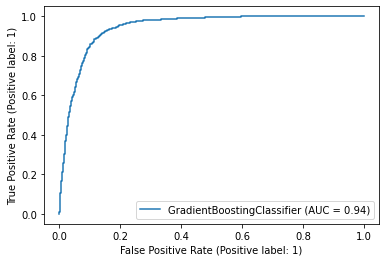

In [40]:
plot_roc_curve(gbc,X_test_standard,y_test)

AUC = 0.94 means that we have a good classifier model for our problem.

# BONUSES

## Feature Importance

In [41]:
#Let's take feature importance coefficients for our model
gbc.feature_importances_

array([0.04728848, 0.00783869, 0.00866984, 0.00421473, 0.00084807,
       0.02706946, 0.01204266, 0.00112189, 0.22893857, 0.6529899 ,
       0.00897771])

In [42]:
#Store it in a dictionary
feats ={}

for feature,importances in zip(X.columns, gbc.feature_importances_):
    feats[feature]=importances    
feats

{'age': 0.04728847559347543,
 'job': 0.007838691216017614,
 'marital': 0.008669840727793976,
 'education': 0.0042147343220379834,
 'default': 0.0008480677491546808,
 'balance': 0.027069459119901943,
 'housing': 0.012042659899547817,
 'loan': 0.0011218909767859058,
 'days_without_contact': 0.22893856753495204,
 'duration': 0.6529899020312833,
 'campaign': 0.008977710829049362}

In [43]:
#then in a data frame
Gini_importance = pd.DataFrame.from_dict(feats, orient="index")

In [44]:
Gini_importance.set_axis(["Gini_Importance"],axis=1, inplace=True)

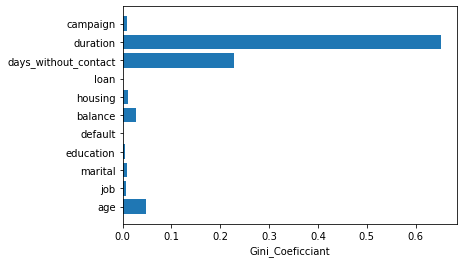

In [45]:
#Plot the feature importances
plt.barh(Gini_importance.index,Gini_importance["Gini_Importance"])
plt.xlabel("Gini_Coeficciant")
plt.show()

It seems like duration and days without contact is the most important 2 features in our data with approximately 88%. So We can may be optimise our duration time in phones and determine the critical days passed without contacting a customer.

In [46]:
duration = pd.crosstab(index=data.duration, columns=data.y)

In [47]:
duration[duration[1]>duration[1].mean()]

y,0,1
duration,,
65,125,3
71,143,2
75,126,2
80,144,5
82,147,2
...,...,...
1721,0,2
1776,0,2
1871,0,2


It seems like we can influance our customers between 65 and 2016 seconds since in those values it performs better from the mean values of overall.

In [48]:
dwc=pd.crosstab(index=data.days_without_contact, columns=data.y)

In [49]:
dwc[dwc[1]>dwc[1].mean()]

y,0,1
days_without_contact,,
36,731,62
37,684,51
38,635,34
39,675,24
40,514,16
...,...,...
324,215,16
325,369,27
326,385,31


It seems like we should have prioritse the customers that we communicated the last 36 and 328 days since those are in the above average of the customers that have term deposit.

## Classification

In [50]:
#At first let's standardise our data and store it in a data frame
scaler = StandardScaler()
scaler.fit(data)
scaler_df = pd.DataFrame(scaler.transform(data), columns=data.columns)

In [51]:
#Import the necessary library which is K Means Cluster
from sklearn.cluster import KMeans

In [52]:
#Let's calculate inertias for each and all clusters
inertias=[]
KMeans()
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(scaler_df)
    inertias.append(kmeans.inertia_)

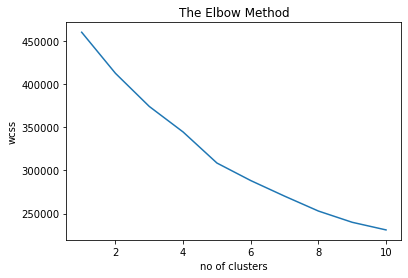

In [53]:
#Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [54]:
#From above, after 5th cluster, inertias improvement started to getting worse. So 5 clusters will be applied.
kmeansmodel = KMeans(n_clusters= 5, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(scaler_df)

In [55]:
#Let's add clusters in our original data
data["Clusters"] = y_kmeans

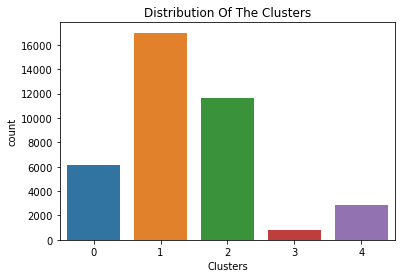

In [56]:
sns.countplot(data=data,x=data["Clusters"]).set_title("Distribution Of The Clusters")
plt.show()

In [57]:
#Let's see which cluster has the customers that have a term deposit
pd.crosstab(index=data.y,columns=data.Clusters)

Clusters,0,1,2,3,4
y,,,,,
0,6140,16991,11615,731,69
1,0,0,0,45,2747


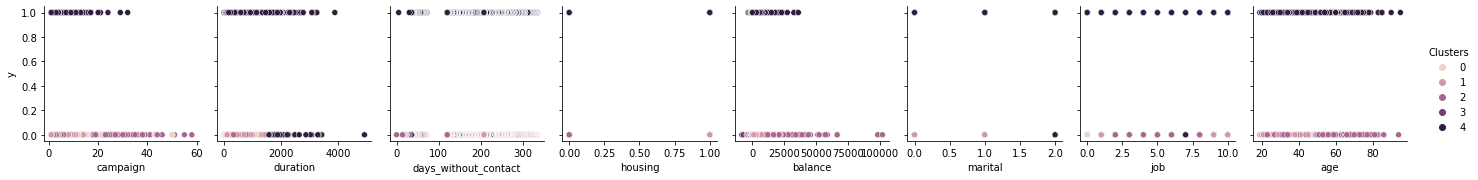

In [58]:
#Let's draw pairplot according to feature importance values.
sns.pairplot(data,x_vars=["campaign","duration","days_without_contact","housing","balance","marital","job","age"],y_vars=["y"],hue="Clusters")
plt.show()

From above, we can clearly state that campaign and balance can give us some insights.

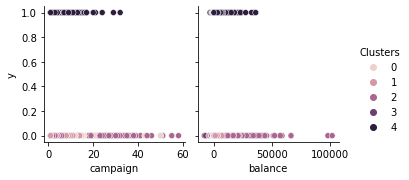

In [59]:
sns.pairplot(data,x_vars=["campaign","balance"],y_vars=["y"],hue="Clusters")
plt.show()

We should focus on the customers that have less than 40 campaigns and have less than 50000 €

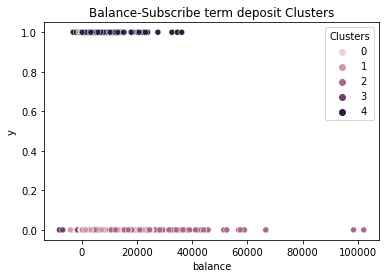

In [60]:
#Let's plot those graphs one by one
sns.scatterplot(data=data,x=data["balance"],y=data["y"],hue=data["Clusters"]).set_title("Balance-Subscribe term deposit Clusters")
plt.show()

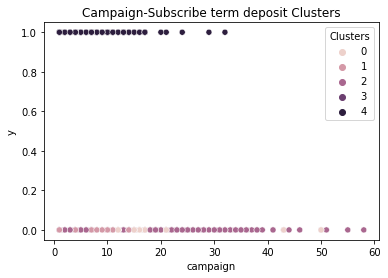

In [61]:
sns.scatterplot(data=data,x=data["campaign"],y=data["y"],hue=data["Clusters"]).set_title("Campaign-Subscribe term deposit Clusters")
plt.show()

## SUMMARY

 In the scope of this project data preprocessing, applying 3 different machine learning classification algorithm and fine tuning parameters has been done. In the scope of the bonus problems, feature importances are determined and customer segmentation has been done.